# Training a Tomato Classification Model
Classes are: Ripe, Rotten, Unripe and Not_tomato


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

## Setup Paths, Mount GDrive
Find the dataset, models etc

In [3]:
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [0]:
_pwd = !pwd

In [6]:
_pwd[0]

'/content/gdrive/My Drive'

In [7]:
# Set the path where the datasets are
path_data = Path(_pwd[0]+'/datasets/tomato_classification'); path_data

PosixPath('/content/gdrive/My Drive/datasets/tomato_classification')

In [8]:
path_data.ls()

[PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_ripe'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_rotten'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/tomato_unripe'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/not_tomato'),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification/models')]

In [9]:
# Path where trained models are saved etc
path_model = Path(_pwd[0]+'/models/tomato_classification'); path_model

PosixPath('/content/gdrive/My Drive/models/tomato_classification')

In [10]:
path_model.ls()

[PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_4epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10_10epochs_err09.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp2.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_stg1_1.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_stg2_err03.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_july18_stg1_err11.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_july18_stg1_err09.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_july18_stg1_err08.pth'),
 PosixPath(

## Create the ImageDataBunch object

In [0]:
bs = 32
np.random.seed(16)
data = ImageDataBunch.from_folder(path_data, valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [12]:
data

ImageDataBunch;

Train: LabelList (722 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe,tomato_ripe
Path: /content/gdrive/My Drive/datasets/tomato_classification;

Valid: LabelList (180 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tomato_rotten,tomato_rotten,not_tomato,not_tomato,tomato_unripe
Path: /content/gdrive/My Drive/datasets/tomato_classification;

Test: None

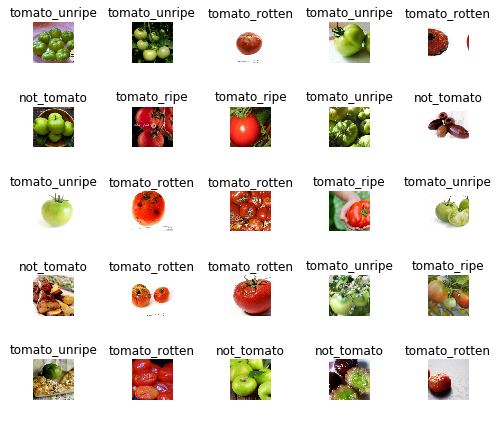

In [0]:
data.show_batch(rows=5, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['not_tomato', 'tomato_ripe', 'tomato_rotten', 'tomato_unripe']


(4, 4)

## Train

### Step 1: Create the Learner
Resnet18 based, with a standard head

In [15]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 18796046.39it/s]


In [0]:
learn.model

In [16]:
learn.loss_func, learn.path

(FlattenedLoss of CrossEntropyLoss(),
 PosixPath('/content/gdrive/My Drive/datasets/tomato_classification'))

### Step 2: First training, and examination of results

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.235749,0.299642,0.100000,00:45
1,0.225556,0.271033,0.083333,00:45


In [0]:
learn.save(path_model/'rn18_july18_stg2_err06')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

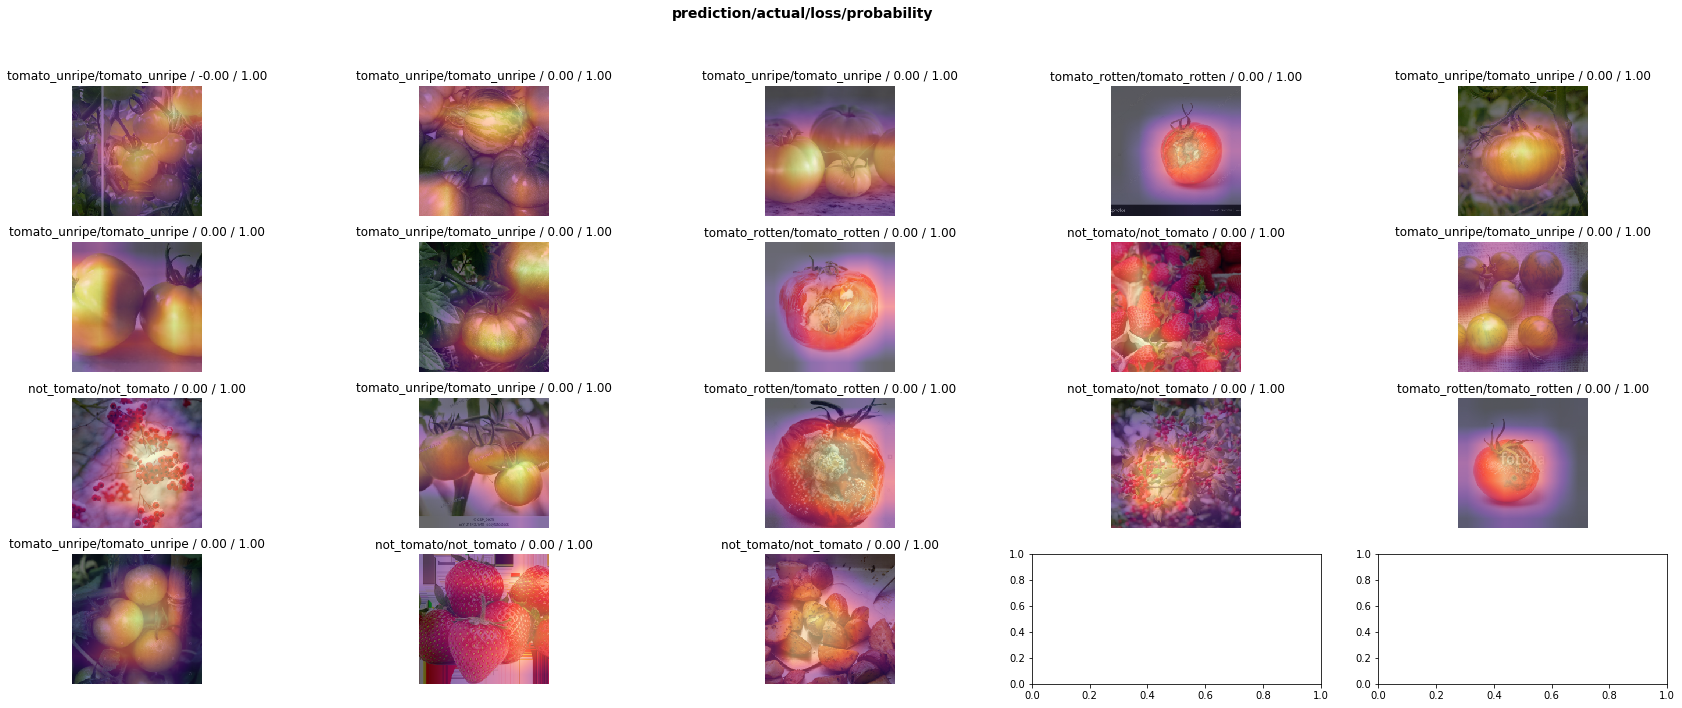

In [0]:
interp.plot_top_losses(18, figsize=(30,11), largest=False)

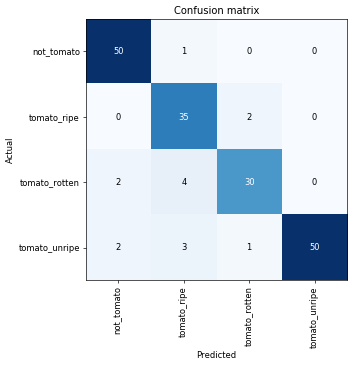

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Step 3: Unfreeze, train again

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


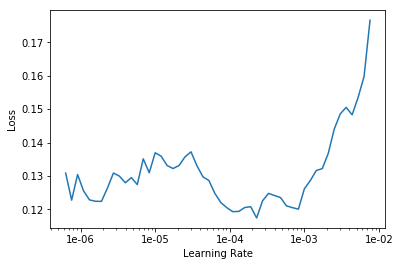

In [0]:
learn.recorder.plot()

In [0]:
learn.load(path_model/'rn18_july18_stg2_err06')

In [0]:
# learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(5e-5,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.137093,0.305890,0.094444,00:46
1,0.158815,0.817523,0.183333,00:44
2,0.172422,0.502058,0.133333,00:44
3,0.149625,0.424881,0.100000,00:44


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

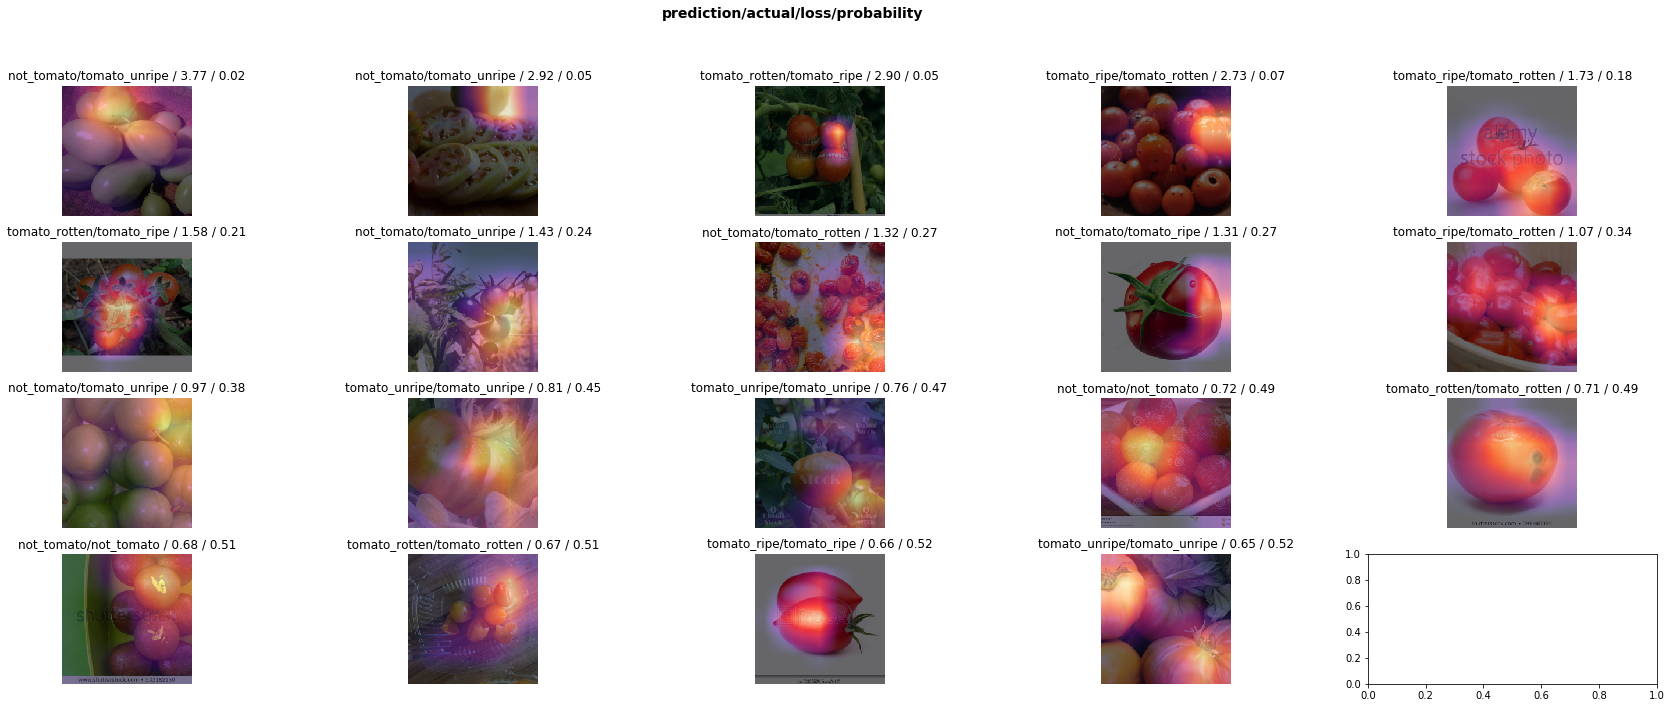

In [19]:
interp.plot_top_losses(19, figsize=(30,11))

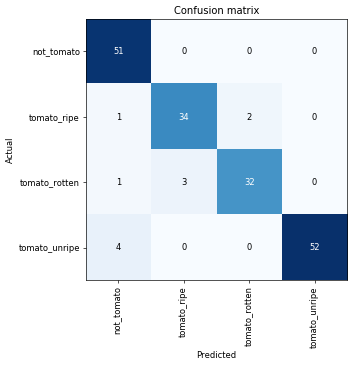

In [20]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Observations
* As per the heatmaps for the top loses, the model is most confused about hands, utensils like plates, pots etc, cut up fruit. 

* Need to add positive classes for the above. hand in the ripe tomato case, remove tomatoes in plates etc

* After adding more hand images in all four categories, the model is no longer flagging those or confused about those. Also removed the image with bowls. The heatmaps are much more focussed on the tomatoes, instead of other things like hands.

In [0]:
learn.export()

In [0]:
path_model.ls()

[PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_4epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet34_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10epochs.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/resnet18_10_10epochs_err09.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/tmp2.pth'),
 PosixPath('/content/gdrive/My Drive/models/tomato_classification/rn18_stg1_1.pth')]

In [0]:
learn.save(path_model/'rn18_july18_stg2_err03')

In [0]:
pip install torchsummary

In [0]:
from torchsummary import summary
summary(learn.model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,